### Import Libraries

In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from modelling_functions import *
from DengueModel import *

import datetime

import warnings
warnings.simplefilter(action="ignore")

# Set all columns and rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Import Models

Do only if the models have already been trained and saved

In [3]:
# model_16wk_lookahead = pickle.load(open('../models/model_16wk_lookahead.sav', 'rb'))
# model_4wk_lookahead = pickle.load(open('../models/model_4wk_lookahead.sav', 'rb'))
# model_8wk_lookahead = pickle.load(open('../models/model_8wk_lookahead.sav', 'rb'))
# model_52wk_lookahead = pickle.load(open('../models/model_52wk_lookahead.sav', 'rb'))

### Import Data

In [4]:
# Import the dataset
data = pd.read_csv('../datasets/data_features_with_lags.csv')

In [5]:
# Check the data
data.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag28,Mean Temperature (°C)_lag51,Mean Wind Speed (km/h)_lag6,Mean Wind Speed (km/h)_lag22,Mean Wind Speed (km/h)_lag47,Maximum Temperature (°C)_lag10,Max Wind Speed (km/h)_lag14,Max Wind Speed (km/h)_lag41,Minimum Temperature (°C)_lag49,dengue_cases_lag_1,dengue_cases_lag_2,dengue_cases_lag_3,s_ratio,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725411,0,0,1,0,0,0,0,0,0,0,0
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,NaN,0.725367,0,0,1,0,0,0,0,0,0,0,0
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,38.0,NaN,0.725189,0,0,1,0,0,0,0,0,0,0,0
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,56.0,38.0,0.725087,0,0,1,0,0,0,0,0,0,0,0
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,55.0,56.0,0.712189,0,0,0,1,0,0,0,0,0,0,0


In [6]:
# Check the shape of the data
data.shape

(257, 37)

In [7]:
# Look at the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   time                            257 non-null    object 
 1   dengue_cases                    257 non-null    int64  
 2   denv_1                          257 non-null    float64
 3   denv_2                          257 non-null    float64
 4   denv_3                          257 non-null    float64
 5   denv_4                          257 non-null    float64
 6   Mean Temperature (°C)           257 non-null    float64
 7   Mean Wind Speed (km/h)          257 non-null    float64
 8   Daily Rainfall Total (mm)       257 non-null    float64
 9   Maximum Temperature (°C)        257 non-null    float64
 10  Max Wind Speed (km/h)           257 non-null    float64
 11  Minimum Temperature (°C)        257 non-null    float64
 12  google_trends                   257 

### Date Processing

The date feature is currently an object time. We will be converting it into a dateTime format.

In [8]:
# Convert the date column into dateTime format
data['time'] = pd.to_datetime(data['time'])

In [9]:
# Set the time as the index
data = data.set_index('time')

In [10]:
# Check the data 
data.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag28,Mean Temperature (°C)_lag51,Mean Wind Speed (km/h)_lag6,Mean Wind Speed (km/h)_lag22,Mean Wind Speed (km/h)_lag47,Maximum Temperature (°C)_lag10,Max Wind Speed (km/h)_lag14,Max Wind Speed (km/h)_lag41,Minimum Temperature (°C)_lag49,dengue_cases_lag_1,dengue_cases_lag_2,dengue_cases_lag_3,s_ratio,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725411,0,0,1,0,0,0,0,0,0,0,0
2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,NaN,0.725367,0,0,1,0,0,0,0,0,0,0,0
2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,38.0,NaN,0.725189,0,0,1,0,0,0,0,0,0,0,0
2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,56.0,38.0,0.725087,0,0,1,0,0,0,0,0,0,0,0
2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,55.0,56.0,0.712189,0,0,0,1,0,0,0,0,0,0,0


In [11]:
data.drop(columns=['denv_1', 'denv_2', 'denv_3', 'denv_4'], inplace=True)

In [12]:
# create a 1-week lag dengue cases variable for prediction
data['dengue_cases_lag_1'] = data['dengue_cases'].shift(1)
data['dengue_cases_lag_2'] = data['dengue_cases'].shift(2)
data['dengue_cases_lag_3'] = data['dengue_cases'].shift(3)

In [13]:
data.drop(columns=['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                   'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
                  'month_12'], inplace=True)

In [14]:
data.drop(columns=['Mean Wind Speed (km/h)', 'Maximum Temperature (°C)', 'Max Wind Speed (km/h)', 'Minimum Temperature (°C)'], inplace=True)

In [15]:
# keep 2023 data as the unseen dataset for final testing
data_subset = data.loc[data.index.year < 2023, :]

In [16]:
# Lag predictors by 1 week to produce 1-week ahead forecast
columns_to_shift = list(data_subset.columns)
columns_to_shift.remove('dengue_cases')

data_subset[columns_to_shift] = data_subset[columns_to_shift].shift(1)

In [17]:
# drop any remaining NA values
data_subset.dropna(inplace=True)

### Train/Test Split

We use the last full year - 2022 - as the test year when doing validation and model choice.

In [16]:
train, test = train_test_split(data_subset, year=2021)

In [17]:
train.shape

(143, 17)

In [18]:
test.shape

(52, 17)

In [93]:
52/143

0.36363636363636365

Overall, this is about a 40% train test split:
* Train: 60% of data
* Test: 40% of data

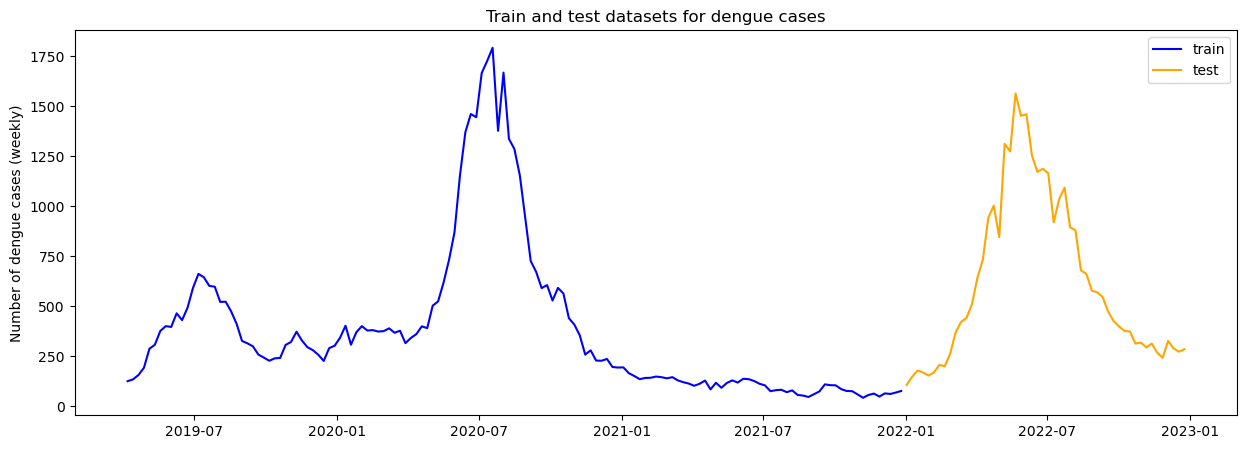

In [20]:
# Time series plot of the train and test data
train_test_plot(train, test, title='Train and test datasets for dengue cases')

## Multi-step Forecasting

Picking the best single-step forecasting models (i.e. Gradient Boosting, Support Vector and Random Forest), we will attempt to build a multi-step forecasting model to enable stakeholders to have advanced warning of a potential dengue outbreak up to 16 weeks ahead.

### Final Model - 16-week Lookahead Model

We will use a combination of the best models to produce a X-week lookahead forecast of dengue cases, where X is the number of weeks determined by the user. We will also create a function to automatically choose the better model when fitting, so that this can be extended to further weeks ahead. This means:
| Week(s) Ahead | Model |
|-----|-----|
| 1 | Random Forest |
| 2 | Random Forest |
| 3 | Random Forest |
| 4 | Gradient Boosting |
| ... | ... |

For the purposes of this project, we will work on a 16-week lookahead model to provide NEA and MOH a lead time of 4 weeks to prepare for an anticipated spike in Dengue cases.

In [21]:
# define the types of models to choose from for each prediction step
model_list = {
    'rf': RandomForestRegressor(),
    'gb': GradientBoostingRegressor(),
    'sv': SVR()
}

In [22]:
# define search grid for hyperparameters
model_searchgrid = {
    'rf': {
           'n_estimators': [500, 800, 1000], 
           'max_features': [0.3, 0.5, 1.0],
           'max_depth': [10, 50, 70],
           'min_samples_split': [2, 5, 11, 19],
           'min_samples_leaf': [1, 3, 5, 7, 9],
          },
    'gb': {
           'n_estimators' : [50, 100, 150],
           'learning_rate' : [0.1, 0.05, 0.01],
           'max_depth' : [3, 5, 7],
           'min_samples_split' : [2, 5, 10],
           'min_samples_leaf' : [1, 2, 4],
           'max_features' : [5, 15, 25, 30]
          },
    'sv': {
           'kernel': ['rbf', 'linear'],
           #'C': [0.1, 1.0, 10, 100],
           #'epsilon': [0.1, 0.3, 0.5, 0.7, 1.0]
          }
}

In [33]:
# define the number of weeks lookahead
weeksahead = 16

In [34]:
# instantiate the custom model object
model_16wk_lookahead = DengueModel(model_list, searchgrid=model_searchgrid, weeks=weeksahead)

In [35]:
# drop any remaining NA values
dataset = data.dropna()

In [36]:
%%time
# fit model
model_16wk_lookahead.fit(dataset.drop(columns='dengue_cases'), dataset['dengue_cases'])

Successfully fitted model for week 1.
Successfully fitted model for week 2.
Successfully fitted model for week 3.
Successfully fitted model for week 4.
Successfully fitted model for week 5.
Successfully fitted model for week 6.
Successfully fitted model for week 7.
Successfully fitted model for week 8.
Successfully fitted model for week 9.
Successfully fitted model for week 10.
Successfully fitted model for week 11.
Successfully fitted model for week 12.
Successfully fitted model for week 13.
Successfully fitted model for week 14.
Successfully fitted model for week 15.
Successfully fitted model for week 16.
CPU times: total: 1min 18s
Wall time: 51min 42s


In [54]:
# compute RMSE of model on test set
model_16wk_lookahead.score(data.loc[data.index.year==2022, :].drop(columns='dengue_cases'), data.loc[data.index.year==2022, 'dengue_cases'])


103.14543218691185

In [83]:
# compute RMSE of model on test set

# convert available 2023 data into sliding window for comparison with prediction
ytrue = series_to_window(data.loc[data.index.year==2023, ['dengue_cases']], n_in=0, n_out=10).head(1)

# do prediction
pred = model_16wk_lookahead.predict(data.loc[[get_date_index(52,2022)], :].drop(columns='dengue_cases')).iloc[:,:10]

# compare predicted and real but only for the first 10 weeks where data is available
mean_squared_error(ytrue, pred, squared=False)

12.978855731541856

Observation:

- Overall performance of model is quite good for 16-week lookahead with RMSE at around 100. It is very good.
- Performance on test data is very good as well and comparable to 8 week performance, which is expected given that there are only 10 datapoints for testing.
- This also suggests that accuracy falls significantly after 10 weeks, since the RMSE for 16 weeks is so much higher than that of 10 weeks.

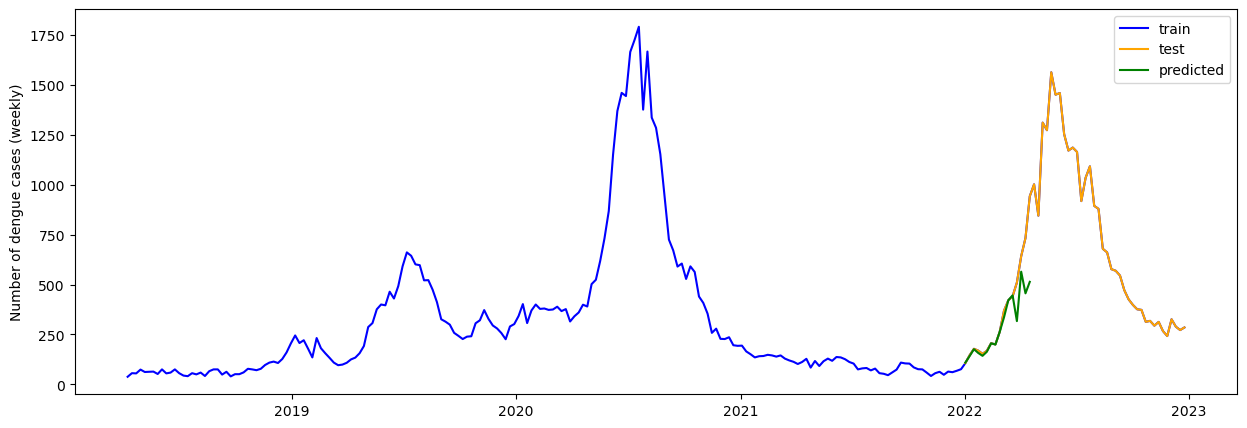

In [84]:
start_point_data = data.loc[[get_date_index(52, 2021)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

train_test_plot(data.loc[data.index.year<=2022,['dengue_cases']], data.loc[data.index.year==2022, ['dengue_cases']], pred)

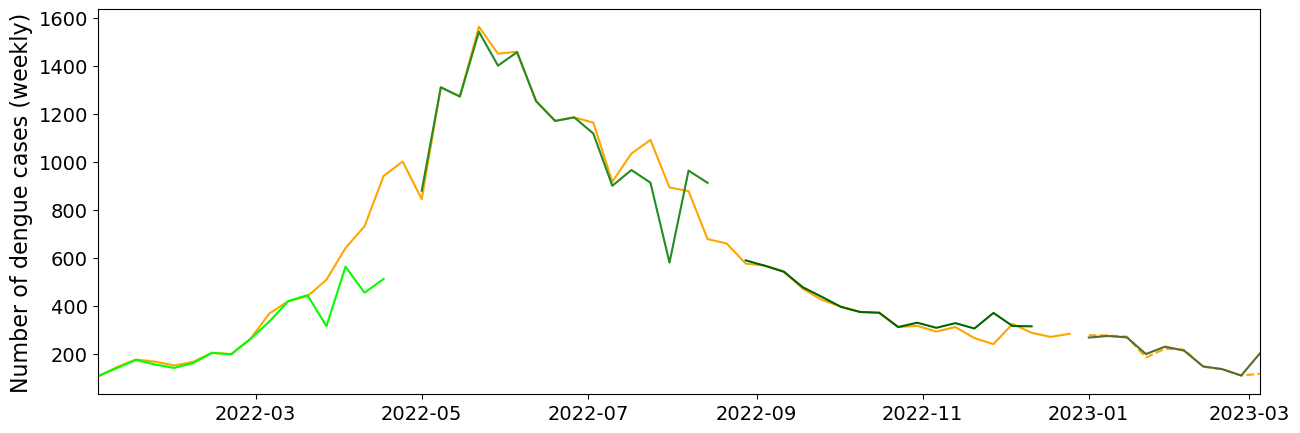

In [96]:
# plotting predictions on validation dataset for presentation

plt.figure(figsize=(15, 5))    
plt.plot(data.loc[data.index.year==2022, ['dengue_cases']], c='orange')

# try week 52 of 2021
start_point_data = data.loc[[get_date_index(52, 2021)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='lime')

# try week 17 of 2022x
start_point_data = data.loc[[get_date_index(17, 2022)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='forestgreen')

# try week 34 of 2022
start_point_data = data.loc[[get_date_index(34, 2022)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='darkgreen')

# put in 2023 test data
plt.plot(data.loc[data.index.year==2023, ['dengue_cases']], c='orange', linestyle='--')

# try week 52 2022
start_point_data = data.loc[[get_date_index(52, 2022)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='darkolivegreen')

plt.ylabel('Number of dengue cases (weekly)', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(get_date_index(1,2022), get_date_index(10,2023))

plt.show()

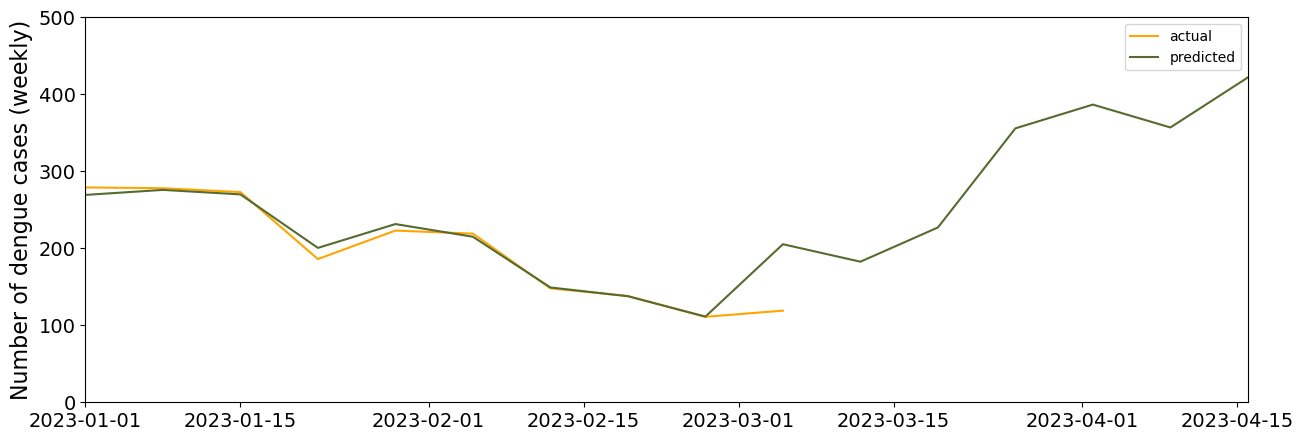

In [144]:
# zoom to just 2023 predictions
plt.figure(figsize=(15, 5))  

plt.plot(data.loc[data.index.year==2023, ['dengue_cases']], c='orange')

# try week 52 2022
start_point_data = data.loc[[get_date_index(52, 2022)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='darkolivegreen')

plt.ylabel('Number of dengue cases (weekly)', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(get_date_index(1,2023), get_date_index(16,2023))
plt.ylim(0, 500)

plt.legend(['actual', 'predicted'])

plt.show()

### Extension: 4-week Lookahead Model

Using the same framework, we try out a 4-week lookahead model

In [23]:
# define the number of weeks lookahead
weeksahead = 4

In [24]:
# instantiate the custom model object
model_4wk_lookahead = DengueModel(model_list, searchgrid=model_searchgrid, weeks=weeksahead)

In [25]:
# drop any remaining NA values
dataset = data.dropna()

In [26]:
%%time
# fit model
model_4wk_lookahead.fit(dataset.drop(columns='dengue_cases'), dataset['dengue_cases'])

Successfully fitted model for week 1.
Successfully fitted model for week 2.
Successfully fitted model for week 3.
Successfully fitted model for week 4.
CPU times: total: 20.6 s
Wall time: 11min 53s


In [45]:
# compute RMSE of model on validation set
model_4wk_lookahead.score(data.loc[data.index.year==2022, :].drop(columns='dengue_cases'), data.loc[data.index.year==2022, 'dengue_cases'])


21.58688095546151

In [44]:
# compute RMSE of model on test set
model_4wk_lookahead.score(data.loc[data.index.year==2023, :].drop(columns='dengue_cases'), data.loc[data.index.year==2023, 'dengue_cases'])


19.973506780663573

Observation:

- Overall performance of model is quite good for 4-week lookahead with RMSE at 21.
- Even on unseen test data, performance of 19 RMSE is very good.

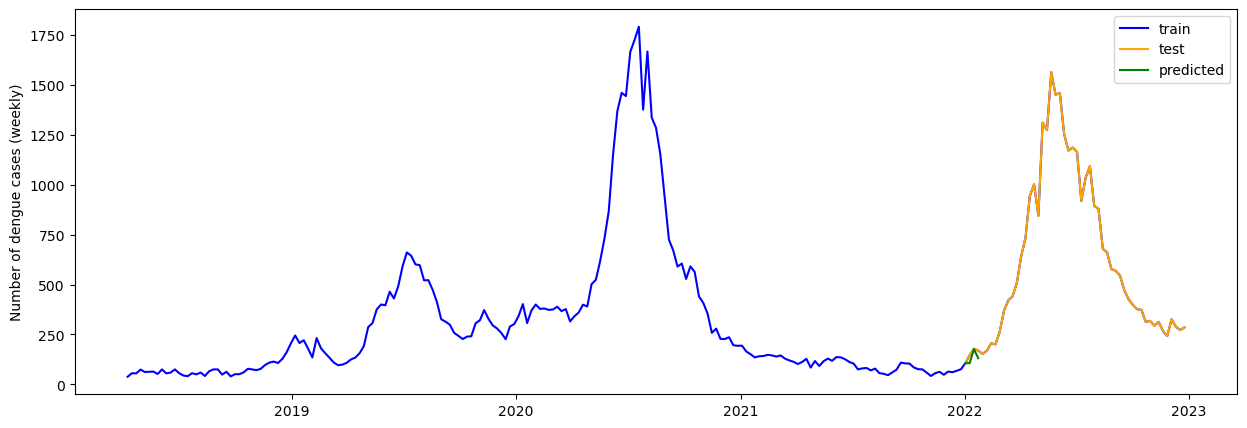

In [47]:
# try prediction and visualise effectiveness
start_point_data = data.loc[[get_date_index(52, 2021)],:].drop(columns='dengue_cases')
pred = model_4wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_4wk_lookahead.weeks+1, freq='W')[1:]

train_test_plot(data.loc[data.index.year<=2022,['dengue_cases']], data.loc[data.index.year==2022, ['dengue_cases']], pred)

### Extension: 8-week Lookahead Model

Using the same framework, we try out a 8-week lookahead model

In [28]:
# define the number of weeks lookahead
weeksahead = 8

In [29]:
# instantiate the custom model object
model_8wk_lookahead = DengueModel(model_list, searchgrid=model_searchgrid, weeks=weeksahead)

In [30]:
# drop any remaining NA values
dataset = data.dropna()

In [31]:
%%time
# fit model
model_8wk_lookahead.fit(dataset.drop(columns='dengue_cases'), dataset['dengue_cases'])

Successfully fitted model for week 1.
Successfully fitted model for week 2.
Successfully fitted model for week 3.
Successfully fitted model for week 4.
Successfully fitted model for week 5.
Successfully fitted model for week 6.
Successfully fitted model for week 7.
Successfully fitted model for week 8.
CPU times: total: 46.2 s
Wall time: 26min 10s


In [51]:
# compute RMSE of model on validation set
model_8wk_lookahead.score(data.loc[data.index.year==2022, :].drop(columns='dengue_cases'), data.loc[data.index.year==2022, 'dengue_cases'])


16.2663444284822

In [52]:
# compute RMSE of model on test set
model_8wk_lookahead.score(data.loc[data.index.year==2023, :].drop(columns='dengue_cases'), data.loc[data.index.year==2023, 'dengue_cases'])


15.907866392423472

Observation:

- Overall performance of model is quite good for 8-week lookahead with RMSE at 16, comparable to the 4-week model.

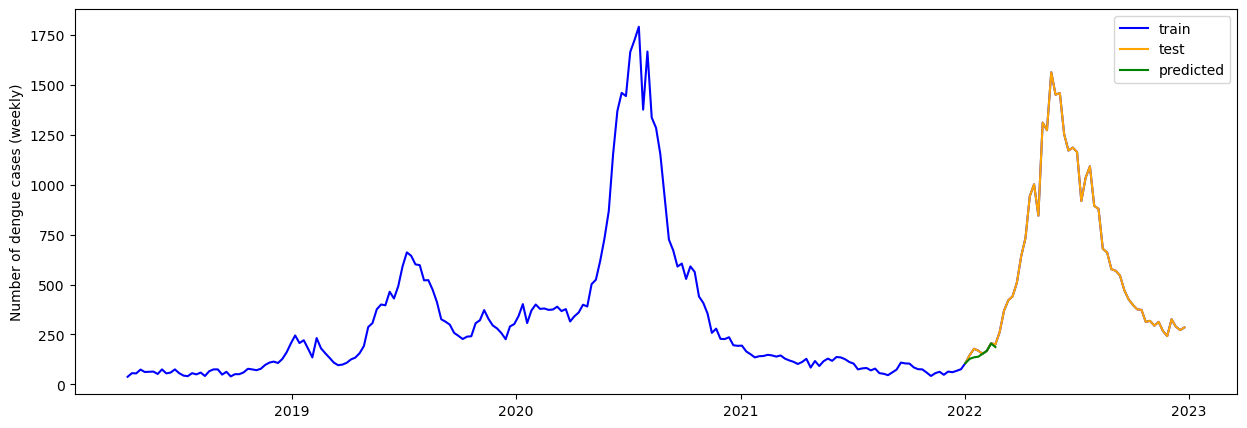

In [50]:
start_point_data = data.loc[[get_date_index(52, 2021)],:].drop(columns='dengue_cases')
pred = model_8wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_8wk_lookahead.weeks+1, freq='W')[1:]

train_test_plot(data.loc[data.index.year<=2022,['dengue_cases']], data.loc[data.index.year==2022, ['dengue_cases']], pred)

### Extension: 52-week Lookahead Model

Using the same framework, we try out a 52-week lookahead model

In [38]:
# define the number of weeks lookahead
weeksahead = 52

In [39]:
# instantiate the custom model object
model_52wk_lookahead = DengueModel(model_list, searchgrid=model_searchgrid, weeks=weeksahead)

In [40]:
# drop any remaining NA values
dataset = data.dropna()

In [41]:
%%time
# fit model
model_52wk_lookahead.fit(dataset.drop(columns='dengue_cases'), dataset['dengue_cases'])

Successfully fitted model for week 1.
Successfully fitted model for week 2.
Successfully fitted model for week 3.
Successfully fitted model for week 4.
Successfully fitted model for week 5.
Successfully fitted model for week 6.
Successfully fitted model for week 7.
Successfully fitted model for week 8.
Successfully fitted model for week 9.
Successfully fitted model for week 10.
Successfully fitted model for week 11.
Successfully fitted model for week 12.
Successfully fitted model for week 13.
Successfully fitted model for week 14.
Successfully fitted model for week 15.
Successfully fitted model for week 16.
Successfully fitted model for week 17.
Successfully fitted model for week 18.
Successfully fitted model for week 19.
Successfully fitted model for week 20.
Successfully fitted model for week 21.
Successfully fitted model for week 22.
Successfully fitted model for week 23.
Successfully fitted model for week 24.
Successfully fitted model for week 25.
Successfully fitted model for week

In [94]:
# compute RMSE on validation set
val_special = pd.concat([data.loc[data.index.year==2022,:], data.loc[[get_date_index(1,2023)], :]], axis=0)
model_52wk_lookahead.score(val_special.drop(columns='dengue_cases'), val_special['dengue_cases'])


132.4375226398458

Observation:

- Overall performance of model is quite good for 52-week lookahead with RMSE at 132 on validation set. It is marginally worse than the 16-week forecast.

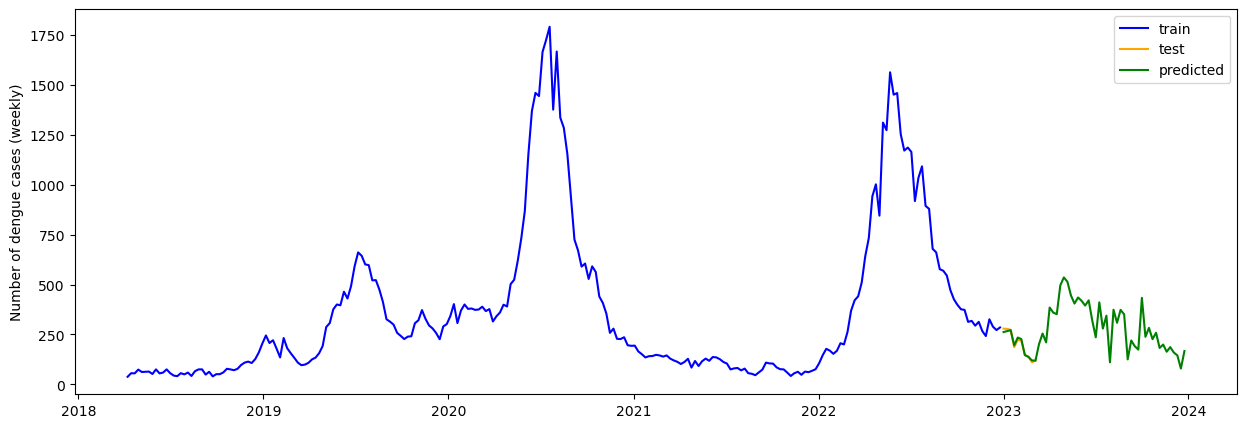

In [148]:
start_point_data = data.loc[[get_date_index(52, 2022)],:].drop(columns='dengue_cases')
pred = model_52wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_52wk_lookahead.weeks+1, freq='W')[1:]

train_test_plot(data.loc[data.index.year<=2022,['dengue_cases']], data.loc[data.index.year==2023, ['dengue_cases']], pred)

### Save Models

In [76]:
# 4-week model
pickle.dump(model_4wk_lookahead, open('../models/model_4wk_lookahead.sav', 'wb'))
# 8-week model
pickle.dump(model_8wk_lookahead, open('../models/model_8wk_lookahead.sav', 'wb'))

In [23]:
# 16-week model
pickle.dump(model_16wk_lookahead, open('../models/model_16wk_lookahead.sav', 'wb'))


In [24]:
# 52-week model
pickle.dump(model_52wk_lookahead, open('../models/model_52wk_lookahead.sav', 'wb'))
